In [1]:
import sys
sys.path.append('../')
import pandas as pd
from processing.processData import process


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In this notebook, we visualize the processed training data.

In [3]:
# import and process data
trainingData = pd.read_pickle('../../../fulldata/processed/trainingData.pkl')
trainingData = process(trainingData)

With trialFeatureVisual, we can visualize each feature in the data per trial as a timeseries.

In [14]:
def trialFeatureVisual(data, subject, trial, feature):
    # cut data to subject and trial
    section = data.query('subject == {} and trial == {}'.format(subject, trial))
    section = section.sort_values('time')
    # get times for the start of each trial phase
    phases = section.groupby('currentobject').first()
    phases = list(zip(phases.index, phases['time'].values))
    
    plt.figure(figsize=(15, 5))
    plt.title('Subject {}, Trial {}, {}'.format(subject, trial, feature))
    sns.scatterplot(x='time', y=feature, data=section)
    
    for phase, phasetime in phases:
        plt.axvline(x=phasetime, color='grey', linestyle='--')
        plt.text(phasetime+20, 1, phase)
        
    start = None
    end = None
    for phase in phases:
        if phase[0] == 'Timer':
            start = phase[1]
        elif phase[0] == 'Feedback':
            end = phase[1]
    
    if ('Timer' in [phase[0] for phase in phases]) and ('Feedback' in [phase[0] for phase in phases]):
        plt.hlines(y=-1, xmin=start, xmax=end, color='black', linestyle='--')
        plt.text(start+20, -1.3, 'RT: {}'.format(str(section['rt'].values[0])[:5]))
    
    plt.ylim(-2, 2)
        
    plt.xticks(np.arange(0, 16, 2)*1000+section['time'].min(), labels=np.arange(0, 16, 2))
    plt.savefig('../../extra/trialFeatureVisual.jpg', dpi=300, bbox_inches='tight')
    plt.show()


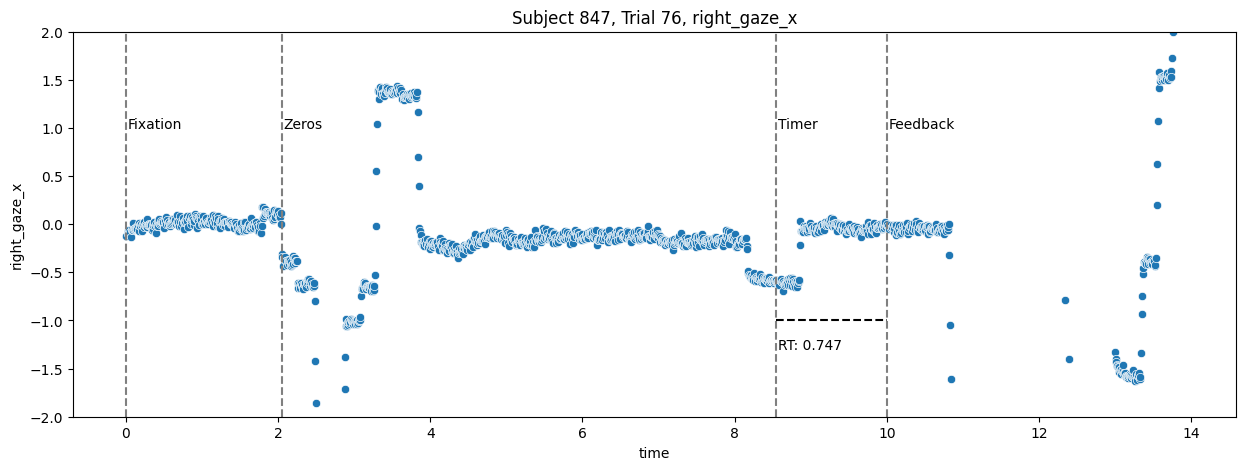

In [15]:
trialFeatureVisual(trainingData, 847, 76, 'right_gaze_x')

In [6]:

def trialFeaturePairplot(data, subject, trial, features='all', phases='all', hue=None):
    # cut data to subject and trial
    section = data.query('subject == {} and trial == {}'.format(subject, trial)).copy()
    
    phasestring = 'All Phases'
    if phases == 'all':
        pass
    else:
        section = section.query('currentobject in "{}"'.format(phases))
        phasestring = 'Phase(s): {}'.format(phases)

    featurestring = 'All Features'    
    if features == 'all':
        features = ['right_gaze_x', 'right_gaze_y', 'left_gaze_x', 'left_gaze_y', 'right_pupil', 'left_pupil']
    else:
        if isinstance(features, str):
            features = [features]
        featurestring = 'Feature(s):'+', '.join(features)
    
    huewrap = []
    huetitle = ''
    if hue:
        huewrap = [hue]
        if hue == 'time':
            huetitle = 'Time (s)'
            starttime = section['time'].min()
            section['time'] = ((section['time']-starttime)/1000).apply(int)
        elif hue == 'currentobject':
            huetitle = 'Phase'
    
    
    
    section = section[features+huewrap].reset_index(drop=True)
    
    # make pairplot
    # sns.pairplot(data = section[['right_gaze_x', 'right_gaze_y', 'left_gaze_x', 'left_gaze_y', 'right_pupil', 'left_pupil', 'time']].reset_index(drop=True), hue='time')
    plot = sns.pairplot(data = section, diag_kind='hist', diag_kws={'bins': 20}, hue=hue)
    plt.suptitle('Subject {}, Trial {}, {}, {}'.format(subject, trial, phasestring, featurestring))
    
    plot._legend.set_title(huetitle)
        
    plt.show()

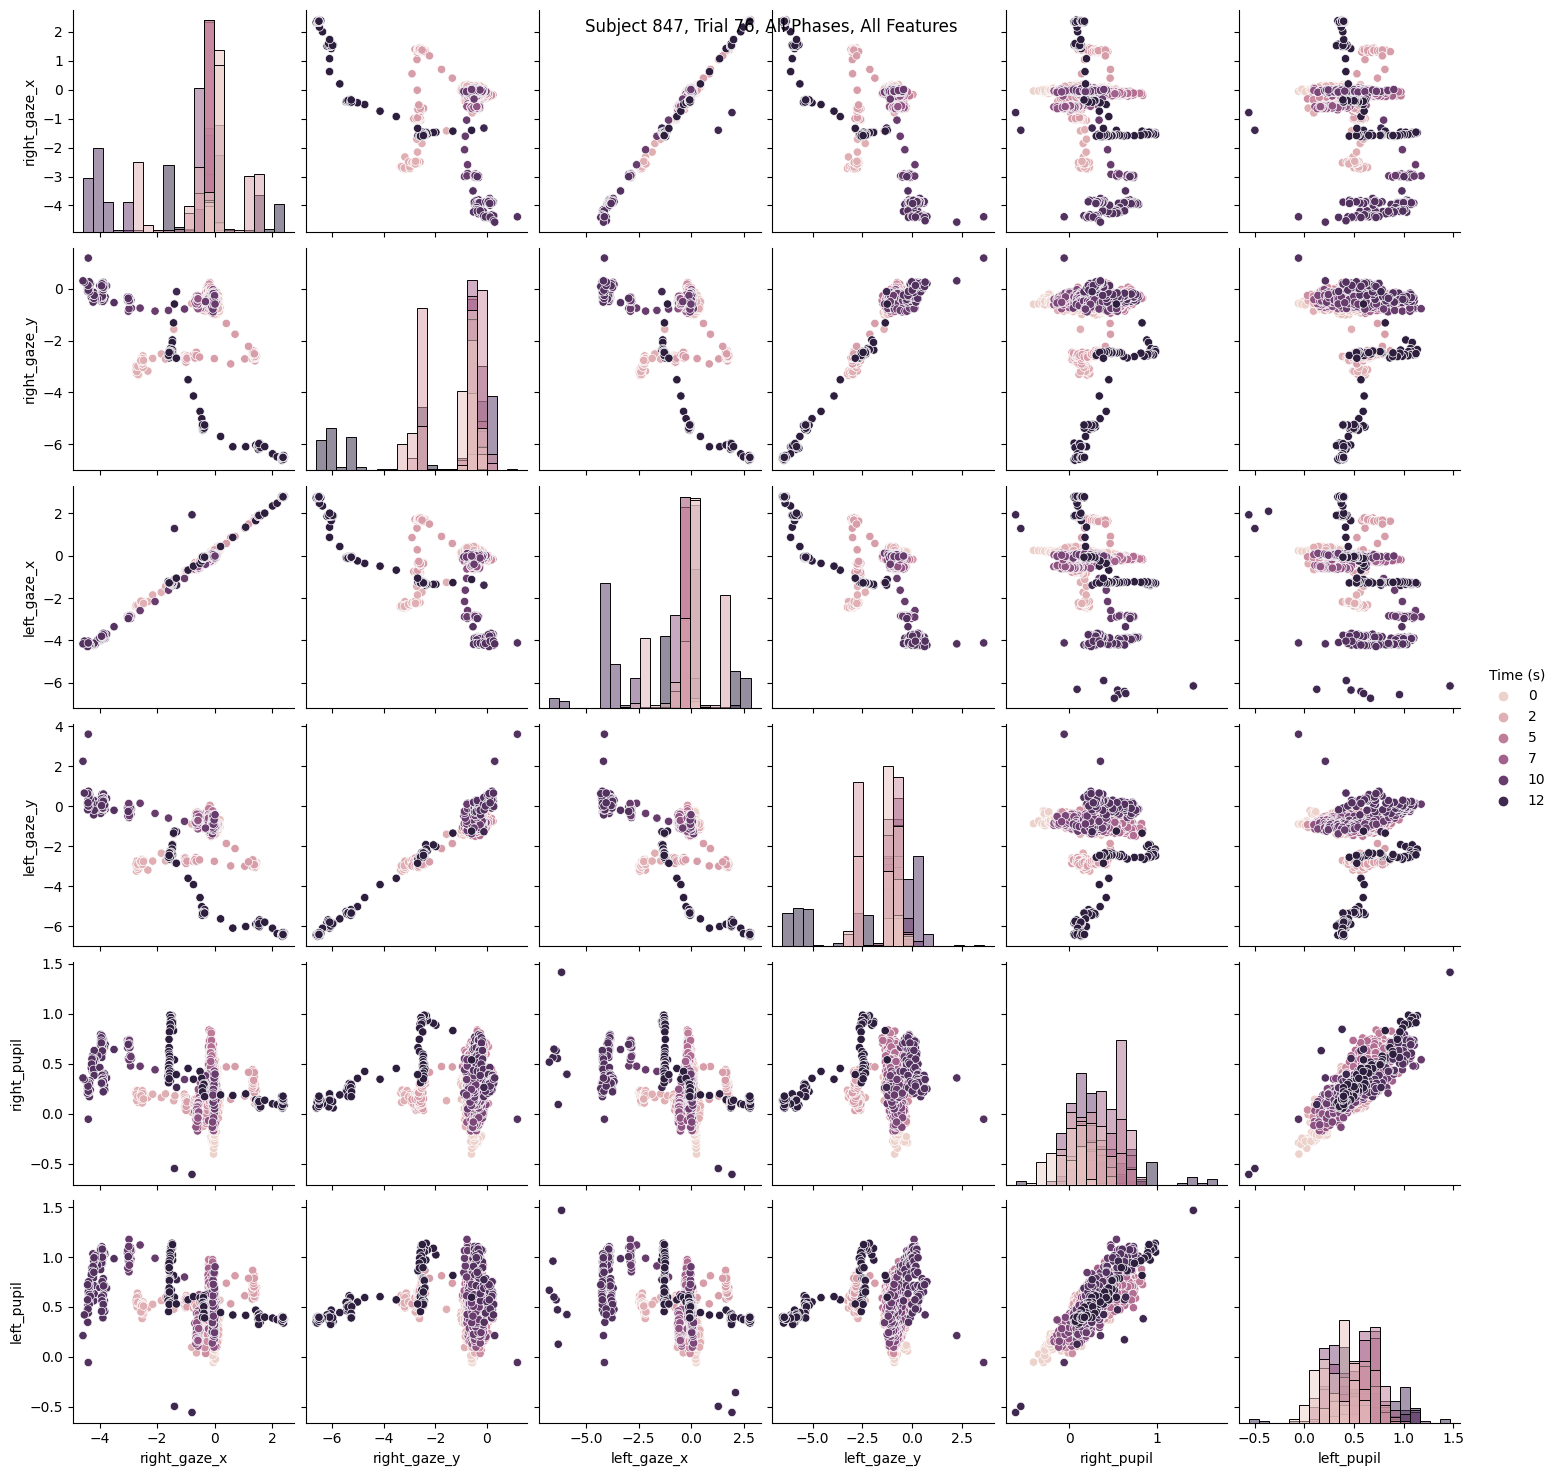

In [7]:
trialFeaturePairplot(trainingData, 847, 76, features='all', phases='all', hue='time')

In [10]:
def trialFeatureAvgPairplot(data, statistic='mean', subjects='all', features='all', phases='all'):
    # cut data to subject and trial
    
    section = data.copy()
    
    subjectstring = 'All Subjects'
    if subjects == 'all':
        pass
    else:
        if isinstance(subjects, int):
            subjects = [subjects]
        subjectstring = 'Subject(s): {}'.format(', '.join([str(s) for s in subjects]))
        section = section.query('subject in {}'.format(subjects))
    
    phasestring = 'All Phases'
    if phases == 'all':
        pass
    else:
        section = section.query('currentobject in "{}"'.format(phases))
        phasestring = 'Phase(s): {}'.format(phases)

    featurestring = 'All Features'    
    if features == 'all':
        features = ['right_gaze_x', 'right_gaze_y', 'left_gaze_x', 'left_gaze_y', 'right_pupil', 'left_pupil']
    else:
        if isinstance(features, str):
            features = [features]
        featurestring = 'Feature(s):'+', '.join(features)

    section = section[features+['subject', 'trial', 'rt']].reset_index(drop=True)
    if statistic == 'mean':
        section = section.groupby(['subject', 'trial']).mean()
    elif statistic == 'median':
        section = section.groupby(['subject', 'trial']).median()
    elif statistic == 'max':
        section = section.groupby(['subject', 'trial']).max()
    elif statistic == 'min':
        section = section.groupby(['subject', 'trial']).min()
    elif statistic == 'std':
        srt = section.groupby(['subject', 'trial']).mean()['rt']
        section = section.groupby(['subject', 'trial']).std()
        section['rt'] = srt
    
    plot = sns.pairplot(data = section, diag_kind='hist', diag_kws={'bins': 20})
    plt.suptitle('Feature Averages Per Trial: {}, {}, {}'.format(subjectstring, phasestring, featurestring))
    plt.savefig('../../extra/FeatureAveragesPerTrial.jpg')
    plt.show()

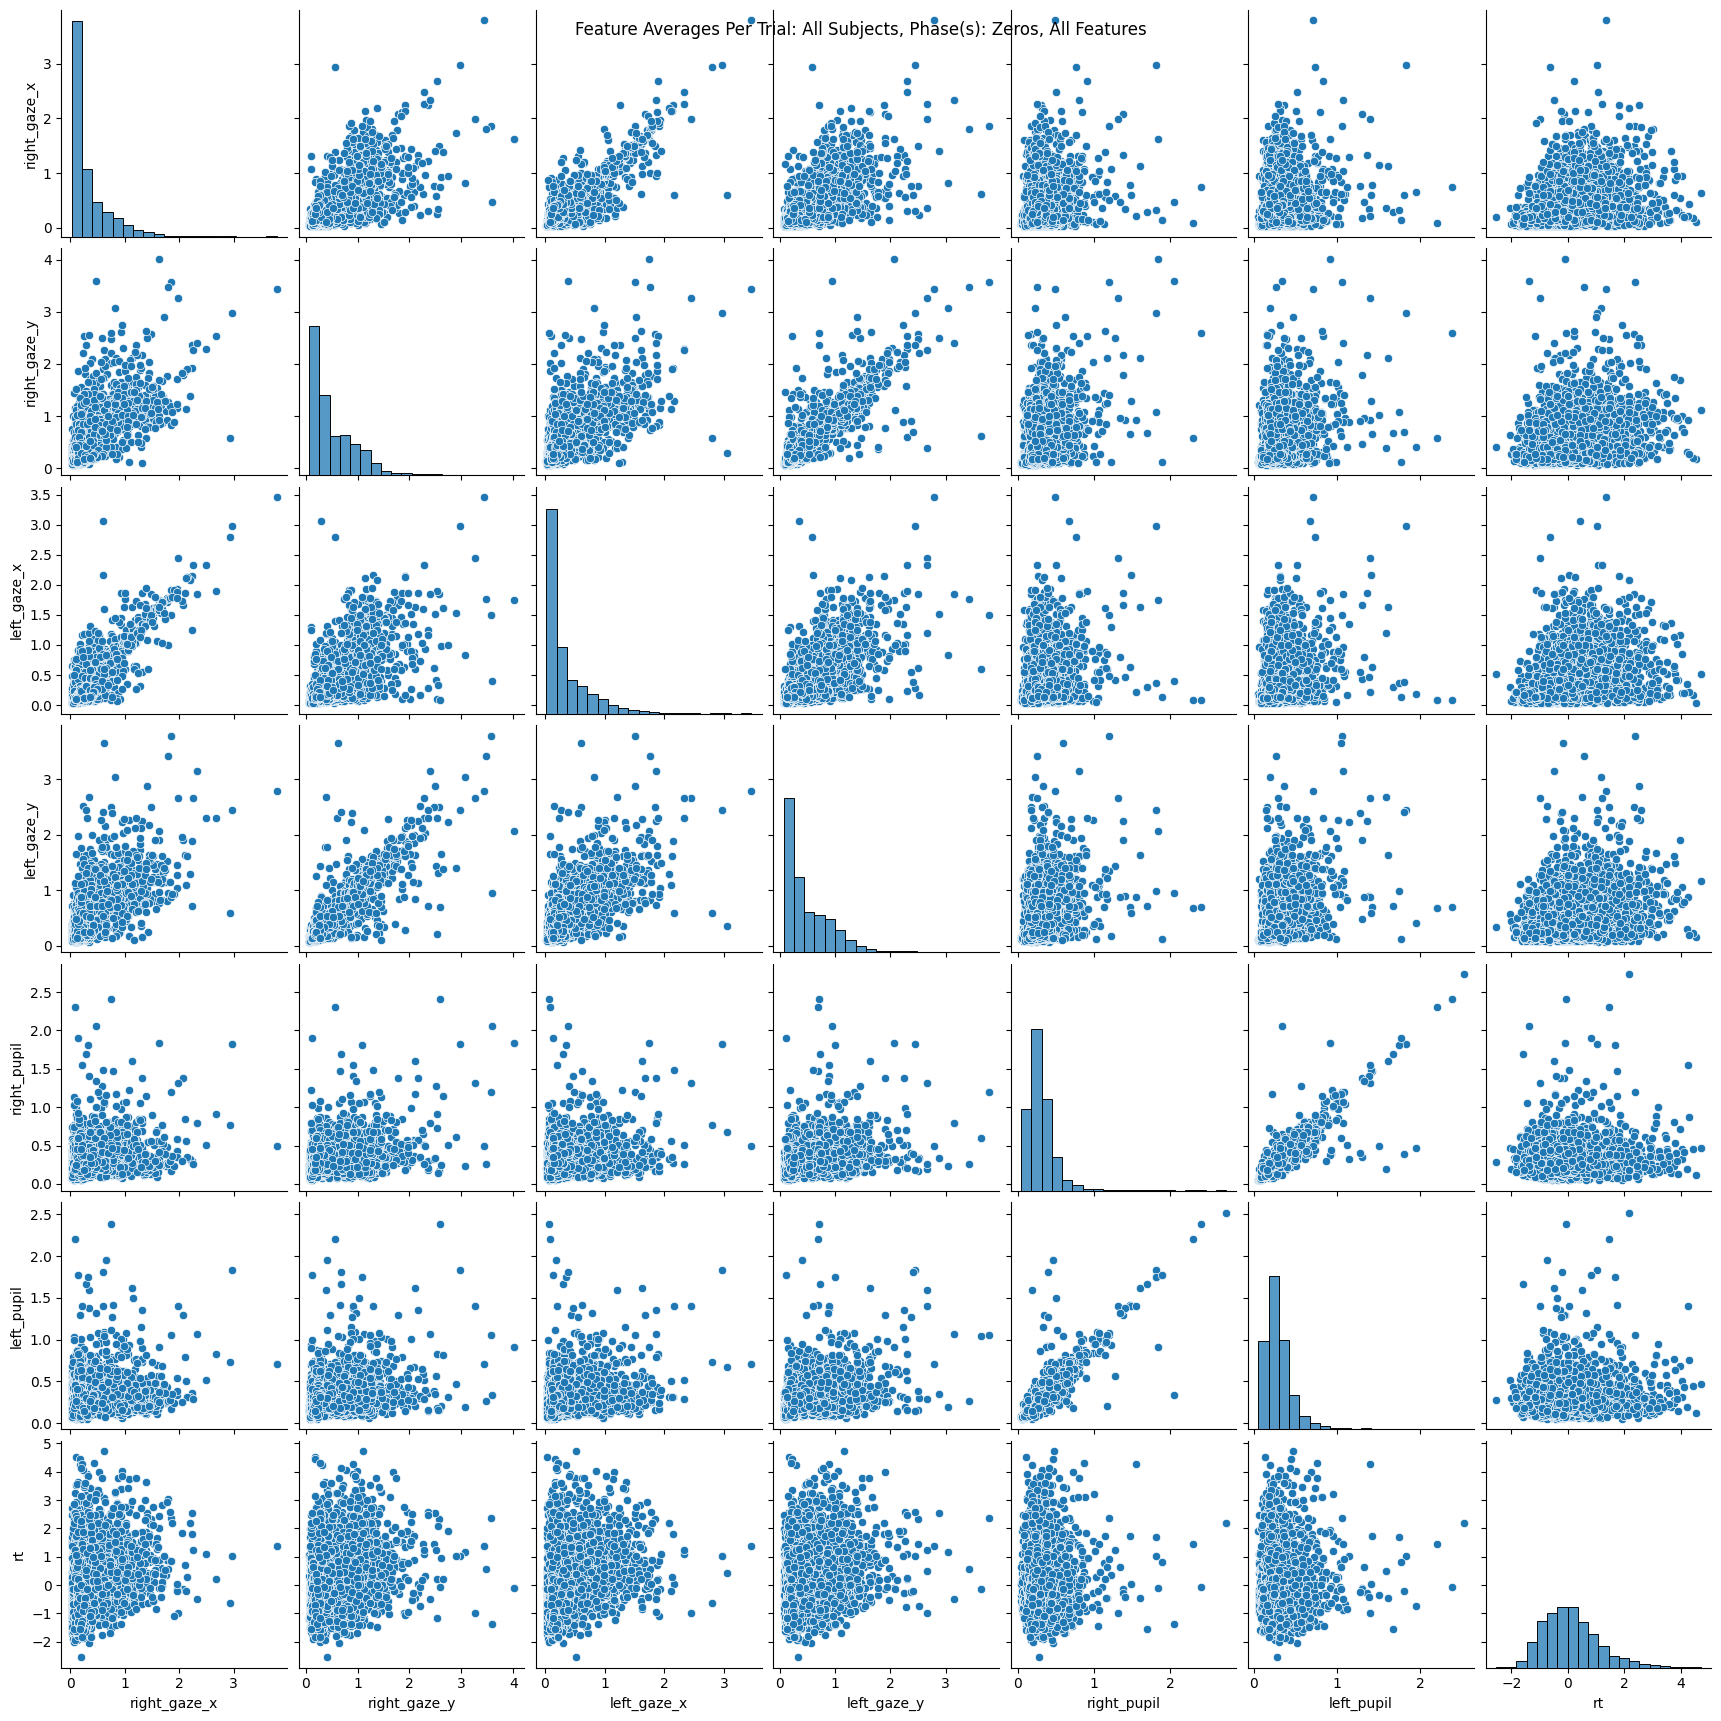

In [11]:
trialFeatureAvgPairplot(trainingData, phases='Zeros', features='all', statistic='std')